In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from mfpml.design_of_experiment.multifidelity_samplers import MFSobolSequence
from mfpml.models.gaussian_process import GaussianProcess
from mfpml.models.kernels import RBF
from mfpml.problems.multifidelity_functions import (
    Forrester_1c,
    Forrester_1a,
    Forrester_1b,
)
from mfbml.methods.mfrbfgp import MFRBFGPR

In [2]:
func = Forrester_1a()

noise = 0.3
# define sampler
sampler = MFSobolSequence(design_space=func.design_space, seed=42)
sample_x = sampler.get_samples(num_hf_samples=50, num_lf_samples=200)

sample_y = {}
# get response
sample_y["hf"] = func.hf(sample_x["hf"]) + np.random.normal(
    0, noise, size=sample_x["hf"].shape[0]
).reshape(-1, 1)
sample_y["lf"] = func.lf(sample_x["lf"]) + np.random.normal(
    0, noise, size=sample_x["lf"].shape[0]
).reshape(-1, 1)

# generate test samples
test_x = np.linspace(0, 1, 1000).reshape(-1, 1)
test_hy = func.hf(test_x)
test_ly = func.lf(test_x)

# generate noisy test data test_x_noisy
test_x_noisy = np.linspace(0, 1, 1000).reshape(-1, 1)
test_hy_noisy = func.hf(test_x_noisy) + np.random.normal(
    0, noise, size=test_x_noisy.shape[0]
).reshape(-1, 1)

In [3]:
# define kernel
gpr = GaussianProcess(
    design_space=func.input_domain, noise_prior=None, optimizer_restart=20
)
gpr.train(sample_x=sample_x["hf"], sample_y=sample_y["hf"])

# get the trained parameters
theta_learned = np.log10(gpr.kernel.param)
noise_learned = gpr.noise

print("theta: ", theta_learned)
print("noise: ", noise_learned)

theta:  [1.90787903]
noise:  2.0


In [4]:
# plot the land scape of  log_likelihood function
#  generate the meshgrid for the parameters theta and noise
theta = np.linspace(-4, 3, 100)
noise = np.linspace(0.01, 2, 100)
theta, noise = np.meshgrid(theta, noise)
# calculate the log_likelihood
log_likelihood_gpr = np.zeros(theta.shape)
for i in range(theta.shape[0]):
    for j in range(theta.shape[1]):
        list_params = [theta[i, j], noise[i, j]]
        log_likelihood_gpr[i, j] = gpr._logLikelihood(params=list_params)
# find the maximum log_likelihood
min_log_likelihood_gpr = np.min(log_likelihood_gpr)
print("max_log_likelihood: ", min_log_likelihood_gpr)
# find the index of the maximum log_likelihood
idx = np.where(log_likelihood_gpr == min_log_likelihood_gpr)
print("theta: ", theta[idx])
print("noise: ", noise[idx])

/tmp/ipykernel_47759/2392250231.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log_likelihood_gpr[i, j] = gpr._logLikelihood(params=list_params)


max_log_likelihood:  104.68717089898277
theta:  [1.7979798]
noise:  [1.25626263]


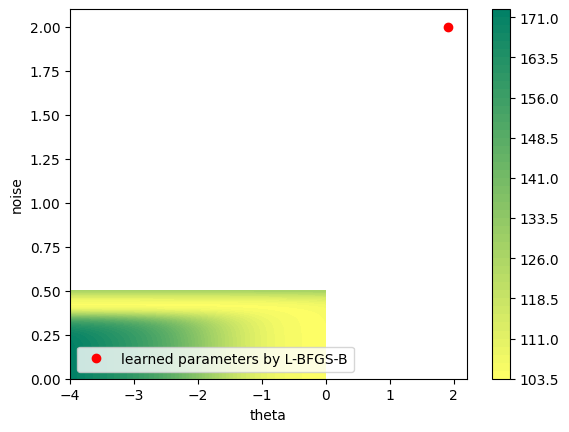

In [17]:
# plot the log_likelihood
fig, ax = plt.subplots()
cs = ax.contourf(theta, noise, log_likelihood_gpr.T,
                 levels=50, cmap=cm.summer_r)
ax.plot(theta_learned, noise_learned, "ro",
        label="learned parameters by L-BFGS-B")
# ax.plot(theta[idx], noise[idx], "b*", label="best parameters by grid search")
ax.legend(loc="lower left")
ax.set_xlabel("theta")
ax.set_ylabel("noise")
fig.colorbar(cs)
plt.savefig("mf_log_likelihood.png", dpi=300, bbox_inches="tight")
plt.show()

gpr:  [80.88705641]
gpr:  [[1.06420332]]
gpr:  2.0


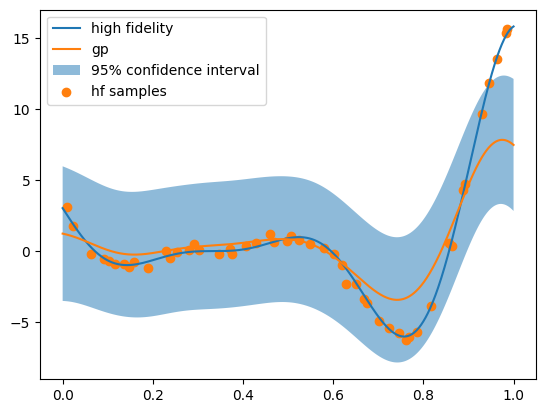

In [6]:
gpr_pred_y, gpr_pred_std = gpr.predict(x_predict=test_x, return_std=True)
print("gpr: ", gpr.kernel.param)
print("gpr: ", gpr.beta)
print("gpr: ", gpr.noise)
# plot
fig, ax = plt.subplots()
ax.plot(test_x, test_hy, label="high fidelity")
ax.plot(test_x, gpr_pred_y, label="gp")
ax.fill_between(
    test_x.flatten(),
    (gpr_pred_y - 1.96 * gpr_pred_std).flatten(),
    (gpr_pred_y + 1.96 * gpr_pred_std).flatten(),
    alpha=0.5,
    label="95% confidence interval",
)
ax.scatter(sample_x["hf"], sample_y["hf"], label="hf samples")
ax.legend()
plt.show()

In [7]:
# for developed methods
# start_time = time.time()
mfrbfgp = MFRBFGPR(
    design_space=func.input_domain, noise_prior=None, optimizer_restart=20
)
mfrbfgp.train(samples=sample_x, responses=sample_y)

In [14]:
#  generate the meshgrid for the parameters theta and noise
theta = np.linspace(-4, 0, 100)
noise = np.linspace(0.0, 0.5, 100)
theta, noise = np.meshgrid(theta, noise)
# calculate the log_likelihood
log_likelihood = np.zeros(theta.shape)
for i in range(theta.shape[0]):
    for j in range(theta.shape[1]):
        list_params = [theta[i, j], noise[i, j]]
        log_likelihood[i, j] = mfrbfgp._logLikelihood(params=list_params)

/tmp/ipykernel_47759/2919413582.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log_likelihood[i, j] = mfrbfgp._logLikelihood(params=list_params)


max_log_likelihood:  -9.434121494033988
theta:  [-4.]
noise:  [0.]


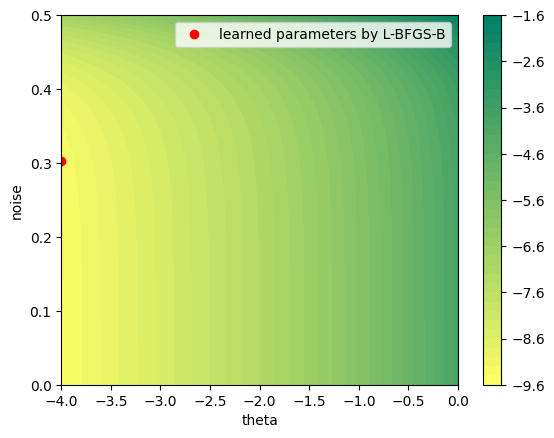

In [16]:
# find the maximum log_likelihood
min_log_likelihood = np.min(log_likelihood)
print("max_log_likelihood: ", min_log_likelihood)
# find the index of the maximum log_likelihood
idx = np.where(log_likelihood == min_log_likelihood)
print("theta: ", theta[idx])
print("noise: ", noise[idx])
# plot the log_likelihood
fig, ax = plt.subplots()
cs = ax.contourf(theta, noise, log_likelihood.T, levels=50, cmap=cm.summer_r)
ax.plot(
    np.log10(mfrbfgp.kernel.param[0]),
    mfrbfgp.noise,
    "ro",
    label="learned parameters by L-BFGS-B",
)
# ax.plot(theta[idx], noise[idx], "b*", label="best parameters by grid search")
ax.legend(loc="best")
ax.set_xlabel("theta")
ax.set_ylabel("noise")
fig.colorbar(cs)
plt.savefig("mf_log_likelihood.png", dpi=300, bbox_inches="tight")
plt.show()

mfrbfgp:  [1.e-04]
mfrbfgp:  [[1.01157799]]
mfrbfgp:  0.30312599917173094


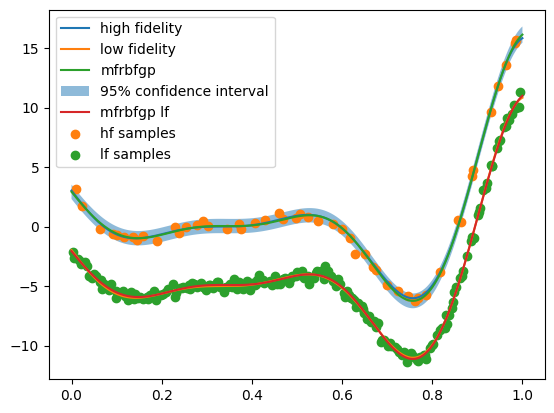

In [10]:
mfrbfgp_pred_y, mfrbfgp_pred_std = mfrbfgp.predict(
    x_predict=test_x, return_std=True)
# get prediction of low fidelity
pred_ly = mfrbfgp.predict_lf(test_xl=test_x)

print("mfrbfgp: ", mfrbfgp.kernel.param)
print("mfrbfgp: ", mfrbfgp.beta)
print("mfrbfgp: ", mfrbfgp.noise)
# plot
fig, ax = plt.subplots()
ax.plot(test_x, test_hy, label="high fidelity")
ax.plot(test_x, test_ly, label="low fidelity")
ax.plot(test_x, mfrbfgp_pred_y, label="mfrbfgp")
ax.fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y - 1.96 * mfrbfgp_pred_std).flatten(),
    (mfrbfgp_pred_y + 1.96 * mfrbfgp_pred_std).flatten(),
    alpha=0.5,
    label="95% confidence interval",
)
ax.plot(test_x, pred_ly, label="mfrbfgp lf")
ax.scatter(sample_x["hf"], sample_y["hf"], label="hf samples")
ax.scatter(sample_x["lf"], sample_y["lf"], label="lf samples")
ax.legend()
plt.show()